In [2]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import random
import tqdm
import datetime
import seaborn as sns

### Download map

![Cordinates for interesting area from bboxfinder.com](bbox.png)

### Prepare data

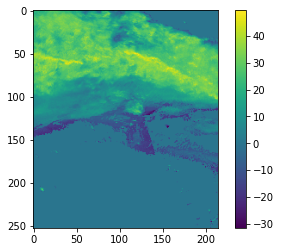

In [5]:
dBZ_radar = np.load('radar_regression.npy')

from radar import marshal_palmer
p_radar = marshal_palmer(dBZ_radar)

plt.imshow(dBZ_radar)
plt.colorbar()

### Polynomial fit and MSE

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

poly_max = 25
regularization = np.linspace(0, 1, 5)
train_mse = np.zeros((poly_max, len(regularization)))
test_mse = np.zeros((poly_max, len(regularization)))

z = dBZ_radar
x = np.arange(z.shape[1])
y = np.arange(z.shape[0])
x, y = np.meshgrid(x, y)

# scale data 
x =  x - np.mean(x) 
y =  y - np.mean(y)
z =  z - np.mean(z) 

k_folds = 7

xyz_shuffle = np.hstack([x.reshape(-1,1), y.reshape(-1,1), z.reshape(-1,1)])
np.random.shuffle(xyz_shuffle) # shuffle along axis 0
xyz_folds = np.array_split(xyz_shuffle, k_folds)

for poly in tqdm.tqdm(range(1, poly_max) ):
    for j in range(len(regularization)):
        MSE_test = []
        MSE_train = []
        for k in range(k_folds):     
            # extract folds
            xyz_test = xyz_folds[k].copy() # k-th fold is test 
            xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold
            xy_train = xyz_train[:, 0:2]
            z_train = xyz_train[:, 2].reshape(-1, 1)
            xy_test = xyz_test[:, 0:2]
            z_test = xyz_test[:, 2].reshape(-1, 1)    
    
                #Scale using train group
                #xy_test[:, 0] =  xy_test[:, 0] - np.mean(xy_train[:, 0]) 
                #xy_test[:, 1] =  xy_test[:, 1] - np.mean(xy_train[:, 1])
                #z_test[:] =  z_test[:] - np.mean(z_train[:]) 
                
                #xy_train[:, 0] =  xy_train[:, 0] - np.mean(xy_train[:, 0])  
                #xy_train[:, 1] =  xy_train[:, 1] - np.mean(xy_train[:, 1])
                #z_train[:] =  z_train[:] - np.mean(z_train[:])
            
                
            model_skl = make_pipeline(PolynomialFeatures(degree=poly), 
                                      Ridge(
                                      alpha=regularization[j], 
                                      fit_intercept=False))
          
            model_skl.fit(xy_train, z_train.ravel()) 
            skl_predict_test = model_skl.predict(xy_test)
            skl_predict_train = model_skl.predict(xy_train)
            MSE_test.append( mean_squared_error(z_test.ravel(), skl_predict_test ) )
            MSE_train.append( mean_squared_error(z_train.ravel(), skl_predict_train ) )
         
        train_mse[poly, j] = np.mean(MSE_train)
        test_mse[poly, j] = np.mean(MSE_test)

 12%|█████▌                                      | 3/24 [00:01<00:09,  2.25it/s]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.20978e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.20158e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.19426e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.2157e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos

 17%|███████▎                                    | 4/24 [00:02<00:12,  1.56it/s]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=9.48166e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=9.41329e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=9.35864e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=9.53131e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_po

 21%|█████████▏                                  | 5/24 [00:03<00:18,  1.02it/s]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.79139e-26): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.77401e-26): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.74006e-26): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.8309e-26): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos

 25%|███████████                                 | 6/24 [00:05<00:25,  1.42s/it]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.77843e-30): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.7657e-30): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.74087e-30): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.80689e-30): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos

 29%|████████████▊                               | 7/24 [00:08<00:32,  1.90s/it]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.23282e-34): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.23232e-34): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.21802e-34): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.25252e-34): result may not be accurate.
  return linalg.solve(A, Xy, sym_po

 33%|██████████████▋                             | 8/24 [00:12<00:38,  2.41s/it]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=8.7067e-39): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=8.7042e-39): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=8.60329e-39): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=8.84241e-39): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=

 38%|████████████████▌                           | 9/24 [00:15<00:39,  2.64s/it]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.12981e-43): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.13712e-43): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.09117e-43): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.20801e-43): result may not be accurate.
  return linalg.solve(A, Xy, sym_po

 42%|█████████████████▉                         | 10/24 [00:19<00:42,  3.07s/it]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.84943e-47): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.85518e-47): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.82343e-47): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.90161e-47): result may not be accurate.
  return linalg.solve(A, Xy, sym_po

 46%|███████████████████▋                       | 11/24 [00:23<00:44,  3.43s/it]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.41248e-51): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.41744e-51): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.40203e-51): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.44318e-51): result may not be accurate.
  return linalg.solve(A, Xy, sym_po

 50%|█████████████████████▌                     | 12/24 [00:28<00:46,  3.86s/it]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=9.59183e-56): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=9.62727e-56): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=9.52305e-56): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=9.79434e-56): result may not be accurate.
  return linalg.solve(A, Xy, sym_po

 54%|███████████████████████▎                   | 13/24 [00:34<00:47,  4.31s/it]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.91359e-60): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.93679e-60): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.88307e-60): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=5.0225e-60): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos

 58%|█████████████████████████                  | 14/24 [00:40<00:48,  4.85s/it]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.29816e-64): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.31371e-64): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.27855e-64): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.3696e-64): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos

 62%|██████████████████████████▉                | 15/24 [00:46<00:48,  5.35s/it]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.73052e-68): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.74006e-68): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.72073e-68): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.7703e-68): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos

 67%|████████████████████████████▋              | 16/24 [00:54<00:47,  5.98s/it]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.15147e-72): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.15717e-72): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.14526e-72): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.17726e-72): result may not be accurate.
  return linalg.solve(A, Xy, sym_po

 71%|██████████████████████████████▍            | 17/24 [01:02<00:46,  6.70s/it]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=6.14466e-77): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=6.19351e-77): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=6.13029e-77): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=6.30283e-77): result may not be accurate.
  return linalg.solve(A, Xy, sym_po

 75%|████████████████████████████████▎          | 18/24 [01:11<00:44,  7.48s/it]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.0611e-81): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.09032e-81): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.05202e-81): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=4.1631e-81): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=

 79%|██████████████████████████████████         | 19/24 [01:22<00:42,  8.42s/it]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.20133e-85): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.22127e-85): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.20195e-85): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.26052e-85): result may not be accurate.
  return linalg.solve(A, Xy, sym_po

 83%|███████████████████████████████████▊       | 20/24 [01:34<00:37,  9.50s/it]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.4471e-89): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.45862e-89): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.44749e-89): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=1.48521e-89): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos

 88%|█████████████████████████████████████▋     | 21/24 [01:46<00:30, 10.24s/it]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=8.01244e-94): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=7.8355e-94): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=7.93186e-94): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=8.19298e-94): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos

 92%|███████████████████████████████████████▍   | 22/24 [02:00<00:23, 11.55s/it]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=5.09677e-98): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=5.30567e-98): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=5.4002e-98): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=5.20993e-98): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos

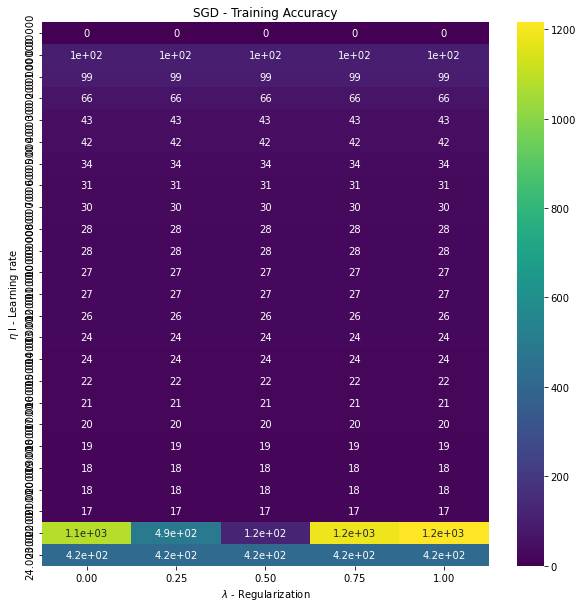

In [14]:
import seaborn as sns

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_mse[:, :], annot=True, ax=ax, cmap="viridis")
ax.set_title("SGD - Training Accuracy")
ax.set_ylabel("$\eta$ l - Learning rate")
ax.set_xlabel("$\lambda$ - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in range(poly_max) ] )
plt.show()

(0.0, 200.0)

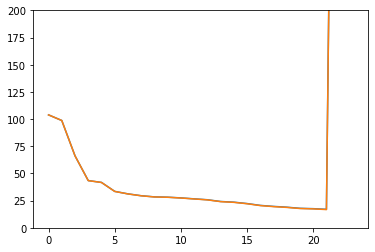

In [15]:
plt.plot(test_mse[1:, 0])
plt.plot(train_mse[1:, 0])
plt.ylim(0, 200)

# Neural Network

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

learning_rate = np.logspace(-5, 0, 6)
regularization = np.linspace(0, 0.1, len(learning_rate))


hidden_layers = [30, 30, 30]

train_mse_nn = np.zeros((len(hidden_layers), len(learning_rate), len(regularization)))
test_mse_nn = np.zeros((train_mse_nn.shape))

z = dBZ_radar
x = np.arange(z.shape[1])
y = np.arange(z.shape[0])
x, y = np.meshgrid(x, y)

k_folds = 7

xyz_shuffle = np.hstack([x.reshape(-1,1), y.reshape(-1,1), z.reshape(-1,1)])
np.random.shuffle(xyz_shuffle) # shuffle along axis 0
xyz_folds = np.array_split(xyz_shuffle, k_folds)

for n_layers in tqdm.tqdm(range(len(hidden_layers))):
    hidden_layer_sizes = [12]*hidden_layers[n_layers] # increases the complexity of the model for eatch iteration. 
    for i in range(len(learning_rate)):
        for j in range(len(regularization)):
            MSE_test = []
            MSE_train = []
            for k in range(k_folds):     
                # extract folds
                xyz_test = xyz_folds[k].copy() # k-th fold is test 
                xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

                xy_train = xyz_train[:, 0:2]
                z_train = xyz_train[:, 2].reshape(-1, 1)
                xy_test = xyz_test[:, 0:2]
                z_test = xyz_test[:, 2].reshape(-1, 1)    
    
                #Scale groups using train mean and std
                #xy_test[:, 0] =  xy_test[:, 0] - np.mean(xy_train[:, 0]) 
                #xy_test[:, 1] =  xy_test[:, 1] - np.mean(xy_train[:, 1])
                #z_test[:] =  z_test[:] - np.mean(z_train[:]) 
                #xy_train[:, 0] =  xy_train[:, 0] - np.mean(xy_train[:, 0])  
                #xy_train[:, 1] =  xy_train[:, 1] - np.mean(xy_train[:, 1])
                #z_train[:] =  z_train[:] - np.mean(z_train[:])

                dnn = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation='logistic', 
                               solver='adam', alpha=regularization[j], 
                               learning_rate_init=learning_rate[i], max_iter=2000)
                
                dnn.fit(xy_train, z_train.ravel())
            
                dnn_zpred_train = dnn.predict(xy_train)
                dnn_zpred_test = dnn.predict(xy_test)            
            
                MSE_test.append( mean_squared_error(z_test.ravel(), dnn_zpred_test ) )
                MSE_train.append( mean_squared_error(z_train.ravel(), dnn_zpred_train ) )
            
            
            train_mse_nn[n_layers, i, j] = np.mean(MSE_train)
            test_mse_nn[n_layers, i, j] = np.mean(MSE_test)

In [ ]:
for layer in range(len(hidden_layers)):
    fig, ax = plt.subplots(figsize = (10, 10))
    sns.heatmap(test_mse_nn[layer, :, :], annot=True, ax=ax, cmap="viridis")
    ax.set_title("SGD - Training Accuracy")
    ax.set_ylabel("$\eta$ l - Learning rate")
    ax.set_xlabel("$\lambda$ - Regularization")
    ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
    ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
    plt.show()

# Decision Tree

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error

leafs_max = 8
train_mse_dt = np.zeros([ leafs_max ])
test_mse_dt = np.zeros([ leafs_max ])

z = dBZ_radar
x = np.arange(z.shape[1])
y = np.arange(z.shape[0])
x, y = np.meshgrid(x, y)

# scale data 
x =  x - np.mean(x) 
y =  y - np.mean(y)
z =  z - np.mean(z) 

k_folds = 7
xyz_shuffle = np.hstack([x.reshape(-1,1), y.reshape(-1,1), z.reshape(-1,1)])
np.random.shuffle(xyz_shuffle) # shuffle along axis 0
xyz_folds = np.array_split(xyz_shuffle, k_folds)

for leafs in tqdm.tqdm(range(0, leafs_max) ):
    MSE_test = []
    MSE_train = []
    for k in range(k_folds):     
        # extract folds
        xyz_test = xyz_folds[k].copy() # k-th fold is test 
        xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

        xy_train = xyz_train[:, 0:2]
        z_train = xyz_train[:, 2].reshape(-1, 1)
        xy_test = xyz_test[:, 0:2]
        z_test = xyz_test[:, 2].reshape(-1, 1)               
            
        clf1 = DecisionTreeClassifier(min_samples_leaf=leafs, random_state=42)
        clf1.fit(xy_train, z_train)

        skl_predict_test = clf1.predict(xy_test)
        skl_predict_train = clf1.predict(xy_train)
        MSE_test.append( mean_squared_error(z_test.ravel(), skl_predict_test ) )
        MSE_train.append( mean_squared_error(z_train.ravel(), skl_predict_train ) )
            
    train_mse_dt[leafs] = np.mean(MSE_train)
    test_mse_dt[leafs] = np.mean(MSE_test)

In [ ]:
for leaf in range(0, leafs_max):
    fig, ax = plt.subplots(figsize = (10, 10))
    sns.heatmap(test_mse_dt[leaf, :, :], annot=True, ax=ax, cmap="viridis")
    ax.set_title("SGD - Training Accuracy")
    ax.set_ylabel("$\eta$ l - Learning rate")
    ax.set_xlabel("$\lambda$ - Regularization")
    ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
    ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
    plt.show()